In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py


In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))

In [5]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [6]:
hf.close()

# Problem 1
1)

Histogram of 4 features


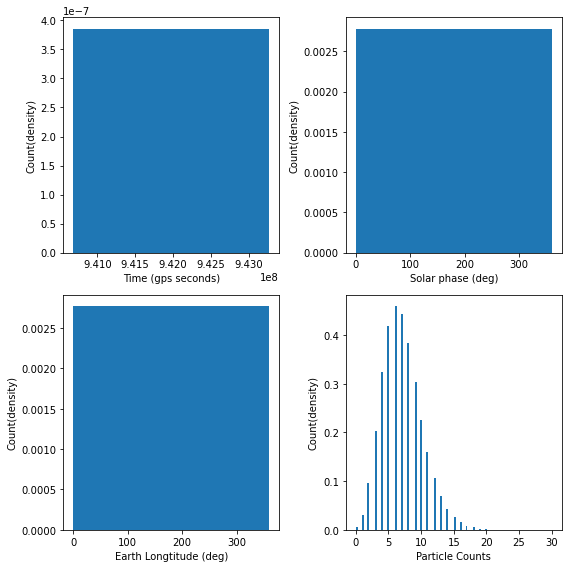

In [7]:
plt.rcParams["figure.figsize"] = (8,8)
print("Histogram of 4 features")
fig, ax = plt.subplots(2, 2)
for i in range(4):
    ax[i//2,i%2].hist(data[i,:],100,density=True)
    ax[i//2,i%2].set_ylabel("Count(density)")
ax[0,0].set_xlabel("Time (gps seconds)")
ax[0,1].set_xlabel("Solar phase (deg)")
ax[1,0].set_xlabel("Earth Longtitude (deg)")
ax[1,1].set_xlabel("Particle Counts")

plt.tight_layout()
plt.show()

From the histograms, we can see that the first three features - time, solar phase, earth longitude, are uniformly distributed, and particle counts is Poisson-like distributed. To verify whether the particle counts is Poisson distributed, we compare it with Poisson(mu=6).

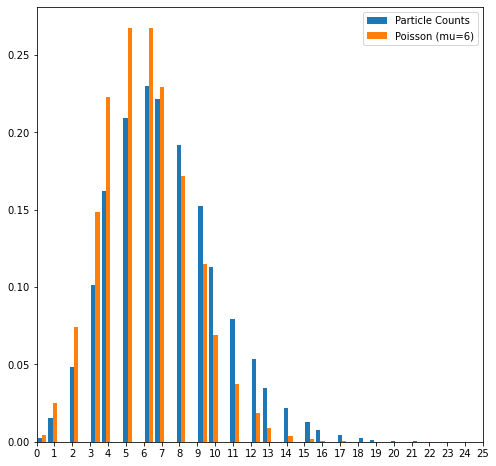

In [8]:
fig, ax = plt.subplots(1,1)
p_dis = stats.poisson.rvs(mu=6, loc=0, size=data.shape[1], random_state=None)
ax.hist([data[3,:],p_dis],50,density=True,rwidth=0.8)
ax.set_xlim([0,25])
ax.set_xticks(np.arange(0,26,1))
ax.legend(['Particle Counts','Poisson (mu=6)'])
plt.show()

Comparing to the Poisson, the distribution of Pariticle Counts has some difference, so there must be contamination.

Histogram of the first 3 features, weighted by Particle counts


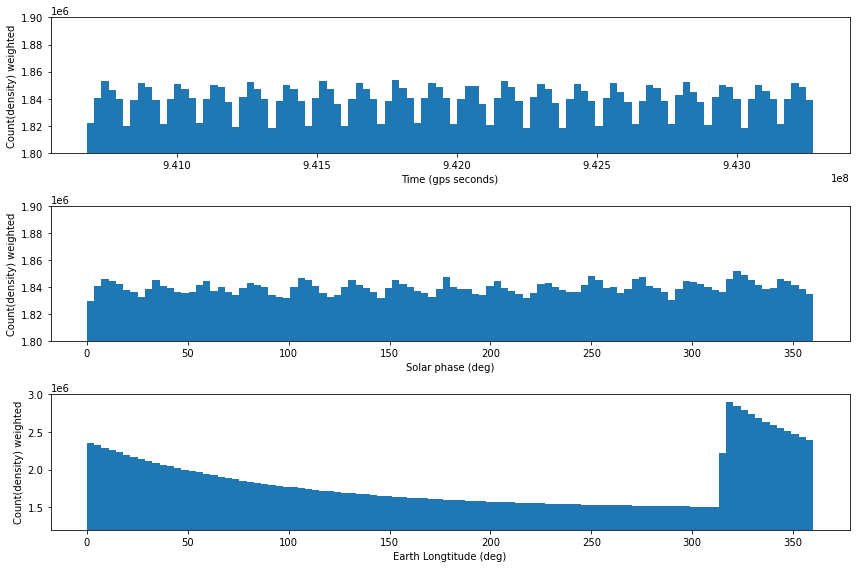

In [9]:
print("Histogram of the first 3 features, weighted by Particle counts")
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots(3, 1)
for i in range(3):
    ax[i].hist(data[i,:],100,weights=data[3,:])
    ax[i].set_ylabel("Count(density) weighted")
ax[0].set_xlabel("Time (gps seconds)")
ax[0].set_ylim([1.8e6,1.9e6])
ax[1].set_xlabel("Solar phase (deg)")
ax[1].set_ylim([1.8e6,1.9e6])
ax[2].set_xlabel("Earth Longtitude (deg)")
ax[2].set_ylim([1.2e6,3e6])

plt.tight_layout()
plt.show()

The plots above show how particle counts varies by the first 3 features. All of them are showing periodic changes. The period of Time and Solar Phase are the same, but Earth Longitude has aparently greater period. I speculate that the data contamination described above originated from this.

In [10]:
def _split (data,minmax):
    if (minmax[0]<minmax[1]):
        return data[:,(data[2]>=minmax[0])&(data[2]<minmax[1])]
    return np.concatenate([data[:,(data[2]>=minmax[0])],data[:,(data[2]<minmax[1])]],axis=1)
def comp_p (data,minmax):
    data = _split(data,minmax)
    d_mean = np.mean(data[3,:])
    return d_mean
def plot_seg(data,minmax):
    data = _split(data,minmax)
    d_mean = np.mean(data[3,:])
    fig, ax = plt.subplots(1,1)
    p_dis = stats.poisson.rvs(mu=d_mean, loc=0, size=data.shape[1], random_state=None)
    ax.hist([data[3,:],p_dis],50,density=True,rwidth=0.8)
    ax.set_xlim([0,25])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0,26,1))
    ax.set_title(str(minmax)+", mean=%.3f"%d_mean)
    ax.legend(['Particle Counts','Poisson (mu=%.3f)'%d_mean])

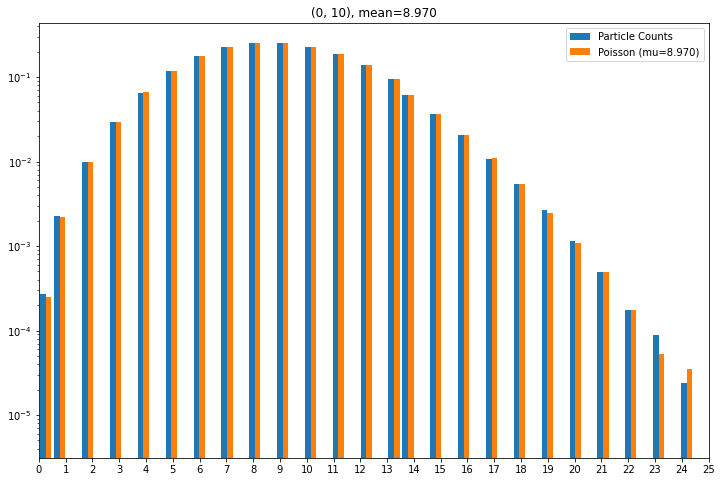

In [11]:
scan = np.arange(0,370,10)
minmax_range = [(scan[i],scan[i+1]) for i in range(scan.shape[0]-1)]
mean_list=[]
for minmax in minmax_range:
    mean = comp_p(data,minmax)
    mean_list.append(mean)
plot_seg(data,minmax_range[0])



I split the longitude into 36 segments with 10 as the step and find that each segment follows Poisson distribution but with different mean value. If I print all the pictures, the html opening speed will be extremely slow, so only print one as an example. <br>Now let's find the pattern of the mean value.

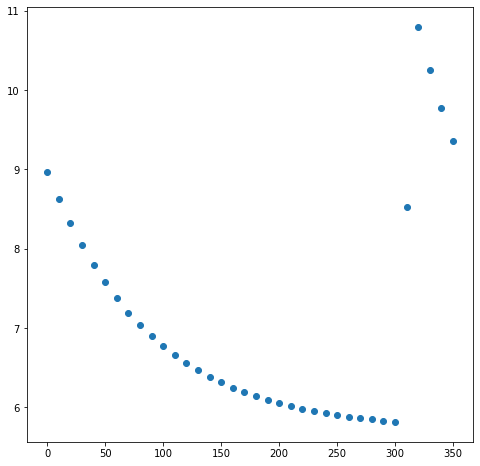

In [12]:
plt.rcParams["figure.figsize"] = (8,8)
fig,ax=plt.subplots(1,1)
ax.scatter(scan[:-1],mean_list)

It seems that the breakpoint is at 310, let's rearrange the x-axis so that 310-360 is connected with 0-300

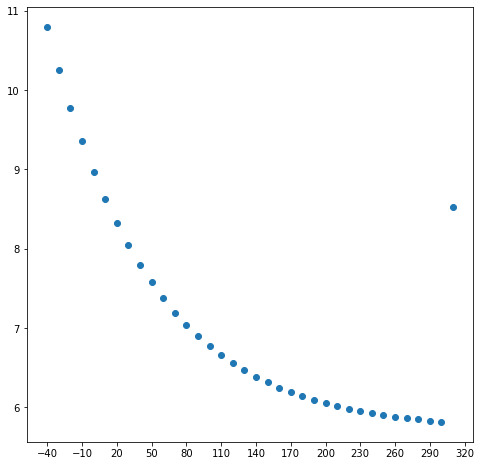

In [13]:

fig,ax=plt.subplots(1,1)
x=np.arange(-40,320,10)
y=np.roll(mean_list,4)
ax.scatter(x,y)
ax.set_xticks(np.arange(-40,340,30))
plt.show()

It seems the pattern follows either exponential or polynomial function. Let's try.

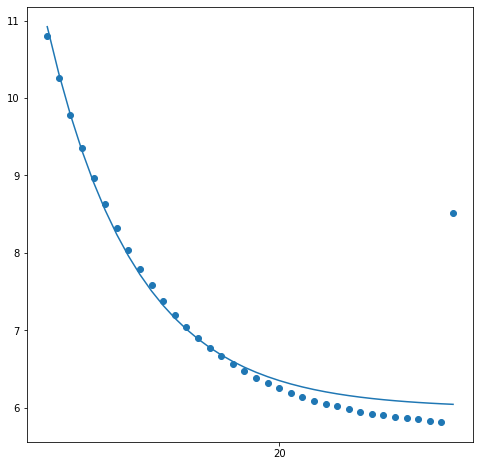

In [14]:
from scipy.optimize import curve_fit

def func(x,a,k,b):
    return a * np.exp(-k*x)+ b
x = np.arange(0,36,1)
opt, _ = curve_fit(func,x,y)
a,k,b = opt

y_pred = func(x,a,k,b)
plt.plot(x,y_pred)
plt.xticks(np.arange(-40,340,30))
plt.scatter(x,y)

It fails in fitting exponential, now let's try polynomial.

            3             2
-2.155e-07 x + 0.0001459 x - 0.03532 x + 9.026


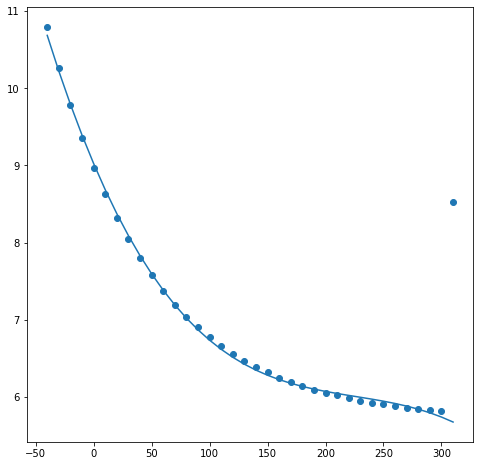

In [15]:
x=np.arange(-40,320,10)
parameter = np.polyfit(x[:-1], y[:-1], 3)
p = np.poly1d(parameter,variable='x')
print(p)

fig,ax=plt.subplots(1,1)
ax.scatter(x,y)
ax.plot(x,p(x))
plt.show()

2) In conclusion, the background is a mixture of Poisson distribution with different mean value. The mean value follows cubic function: -2.155e-07 x^3 + 0.0001459 x^2 - 0.03532 x + 9.026 except the aberrant point at longitude=310. The variable x represent Earth Longitude.
3) To find out the relationship between Particle counts and time, let's take first 100k data and make a hist2D plot. If we use the whole dataset, the pattern vanishes.

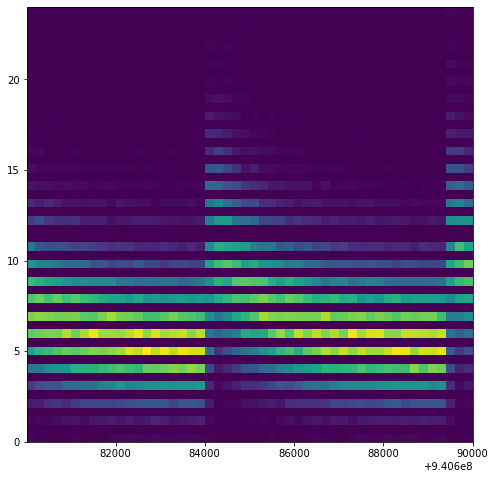

In [16]:
plt.hist2d(data[0,:100000],data[3,:100000],50)
plt.show()

3) From y-axis, it looks like a Poisson distribution, and from x-axis, the shape is periodic and looks like an Exponential distribution. Let's split it as what we did on longitude.

In [17]:
def _split_t (data,minmax):
    if (minmax[0]<minmax[1]):
        return data[:,(data[0]>=minmax[0])&(data[0]<minmax[1])]
    return np.concatenate([data[:,(data[0]>=minmax[0])],data[:,(data[0]<minmax[1])]],axis=1)
    
def comp_p_t (data,minmax):
    data = _split_t(data,minmax)
    d_mean = np.mean(data[3,:])
    return d_mean

def plot_seg_t(data,minmax):
    data = _split_t(data,minmax)
    d_mean = np.mean(data[3,:])
    fig, ax = plt.subplots(1,1)
    p_dis = stats.poisson.rvs(mu=d_mean, loc=0, size=data.shape[1], random_state=None)
    ax.hist([data[3,:],p_dis],50,density=True,rwidth=0.8)
    ax.set_xlim([0,25])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0,26,1))
    ax.set_title(str(minmax)+", mean=%.3f"%d_mean)
    ax.legend(['Particle Counts','Poisson (mu=%.3f)'%d_mean])

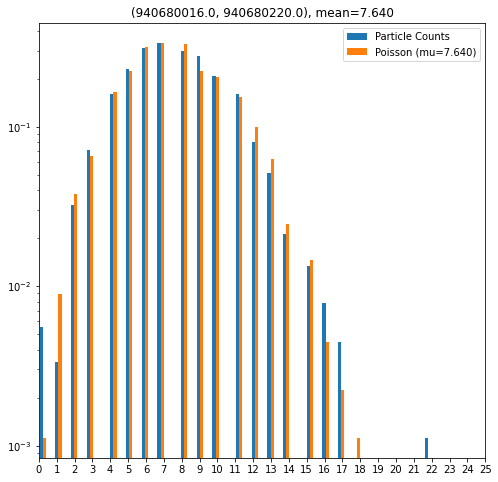

In [18]:
data_part = data[:,:100000]
minmax_t = np.linspace(data_part[0,0],data_part[0,-1],50)
minmax_t = np.round(minmax_t)
minmax_range_t = [(minmax_t[i],minmax_t[i+1]) for i in range(minmax_t.shape[0]-1)]
mean_list_t = []
for minmax in minmax_range_t:
    mean_t = comp_p_t(data_part,minmax)
    mean_list_t.append(mean_t)

plot_seg_t(data_part,minmax_range_t[0])

By splitting into 50 segments, the distribution of particle counts is close enough to be seen as Poisson. If I print all the pictures, the html opening speed will be extremely slow, so only print one as an example.<br>
Next step, I'm gonna see how the mean value varies with respect to time.

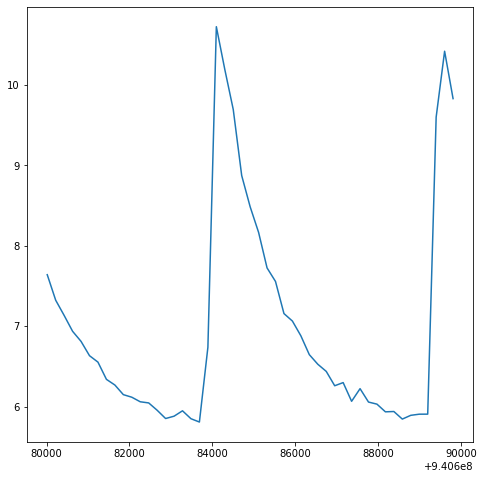

In [19]:
plt.plot(minmax_t[:-1],mean_list_t)
plt.show()

Now, let's take one period and explore the function.

The period is 5510 seconds.


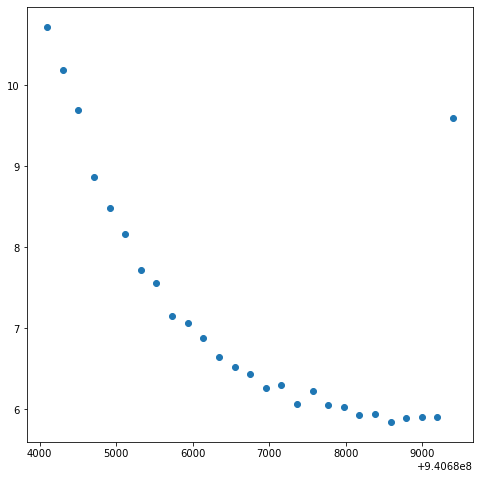

In [20]:
temp_arr = np.array(mean_list_t)
max_1 = temp_arr.max()
max_2 = temp_arr[temp_arr!=max_1].max()
ind_1 = int(np.where(temp_arr==max_1)[0])
ind_2 = int(np.where(temp_arr==max_2)[0])

xrange = minmax_t[:-1]
plt.scatter(xrange[ind_1:ind_2],mean_list_t[ind_1:ind_2])
print("The period is %s seconds."%int(np.round(xrange[ind_2]-xrange[ind_1])))

y = 4.8e^(-0.2x) + 6.2


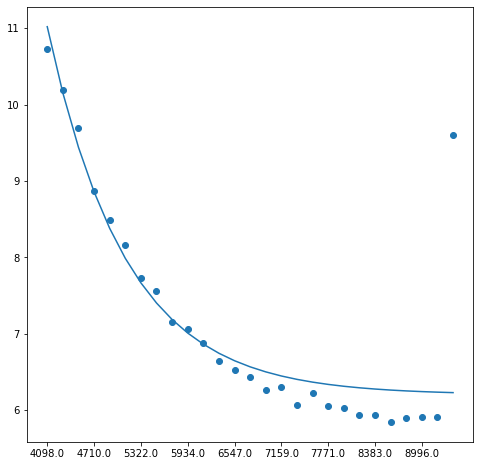

In [21]:
x = np.arange(0,xrange[ind_1:ind_2].shape[0],1)
y = mean_list_t[ind_1:ind_2]
opt, _ = curve_fit(func,x,y)
a,k,b = opt
print("y = %.2ge^(-%.2gx) + %.2g"%(a,k,b))

y_pred = func(x,a,k,b)
plt.xticks(np.arange(0,xrange[ind_1:ind_2].shape[0],3),xrange[ind_1:ind_2][slice(0,xrange[ind_1:ind_2].shape[0],3)]-9.4068e8)
plt.plot(x,y_pred)
plt.scatter(x,y)
plt.show()

The exponential equation y = 4.8e^(-0.2x) + 6.2 fits the pattern of the average change over time well, so we can say that gamma-ray obeys the Poisson distribution and changes exponentially in time. In addition, this change is periodic with a period of 5510 seconds, which is close to 90 minute orbital time (5400 s).<br>
<br>
4) 100 millisecond = 0.1 s. Since we are given the data in seconds, we need to divide the mean and significance by 10. To keep the answer simple, I'll randomly pick 5 points in a period.

In [22]:
times = np.sort(np.random.choice(xrange[ind_1:ind_2],size=5, replace=False))
means=[]
for i in times:
    means.append(mean_list_t[int(np.where(minmax_t==i)[0])])
five_points = dict(zip(times,means))
prob = stats.norm.sf(5)
for t,m in five_points.items():
    sig = stats.poisson.isf(prob, m)
    print("At (%d+9.4068e8) seconds, for a 100 millisecond GRB, the mean is %.2f, the '5-sigma' threshold is %.2f."%(t-9.4068e8,m/10,sig/10))
    

At (4098+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 1.07, the '5-sigma' threshold is 3.10.
At (4302+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 1.02, the '5-sigma' threshold is 3.00.
At (5526+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 0.76, the '5-sigma' threshold is 2.50.
At (5934+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 0.71, the '5-sigma' threshold is 2.40.
At (6342+9.4068e8) seconds, for a 100 millisecond GRB, the mean is 0.66, the '5-sigma' threshold is 2.30.


# Problem 2
1) I'm looking for a transient supernova.

In [23]:
with h5py.File('images.h5','r') as f:
    data=f['imagestack'][()]
    data1 = f['image1'][()]

2)

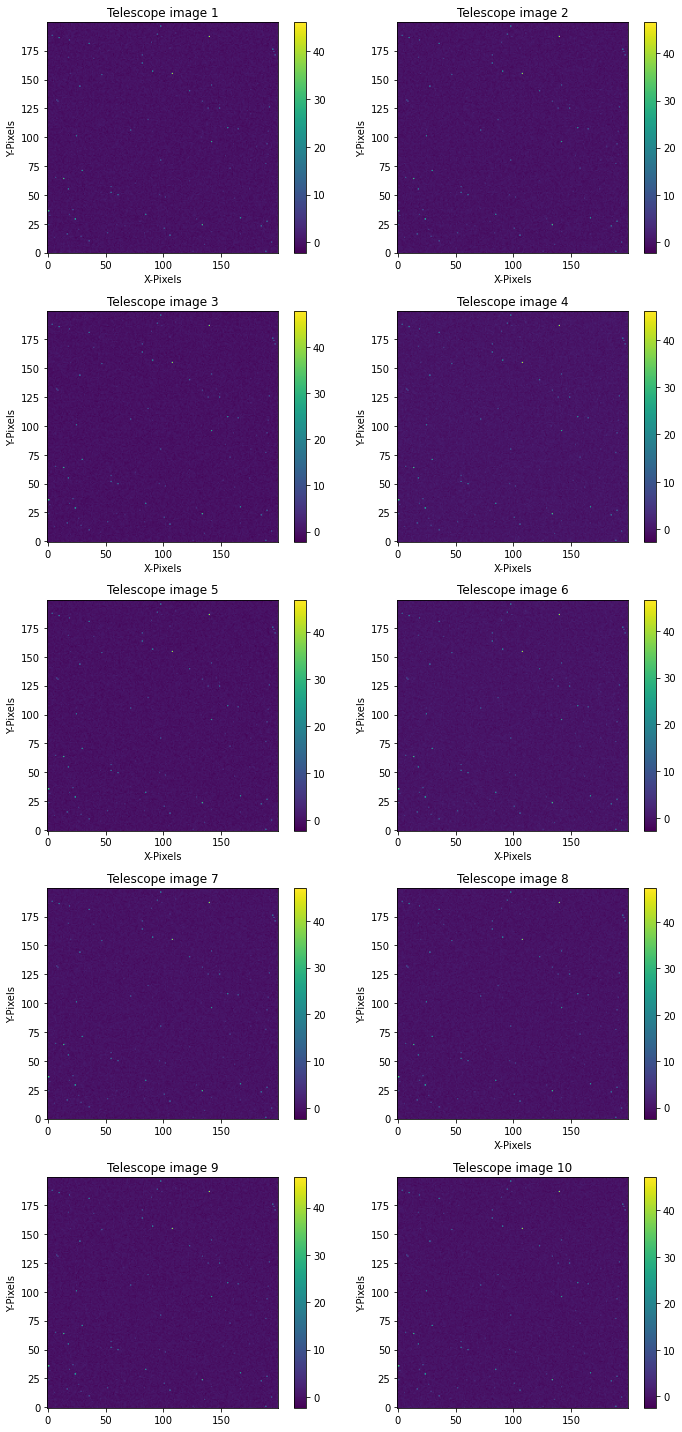

In [24]:
plt.rcParams["figure.figsize"] = (10,20)
fig,ax=plt.subplots(5,2)
for i in range(data.shape[2]):
    img = ax[i//2,i%2].imshow(data[:,:,i], origin='lower')
    ax[i//2,i%2].title.set_text('Telescope image %s'%(i+1))
    ax[i//3,i%2].set_xlabel('X-Pixels')
    ax[i//2,i%2].set_ylabel('Y-Pixels')
    fig.colorbar(img, ax=ax[i//2,i%2])
plt.tight_layout()
plt.show()


These graph are bootless, it is impossible to perceive supernovae by eyes.<br>
Instead, since supernovae are ephemeral, let's take subtraction between the nearest two images and expect a significant difference, either positive or negative.


In [25]:
img_diff = []
for i in range(1,10):
    img_diff.append(data[:,:,0]-data[:,:,i])

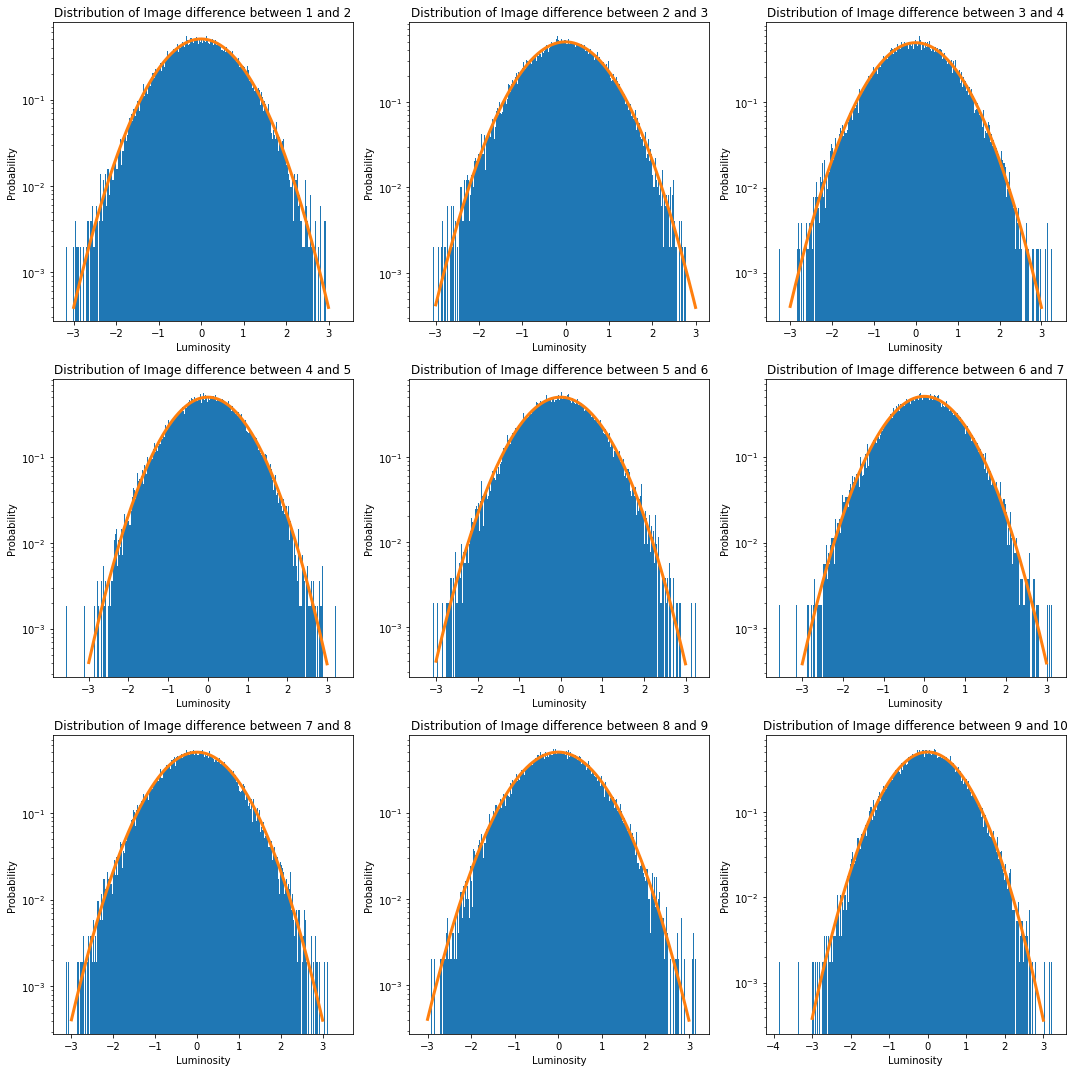

In [26]:
means = np.mean(img_diff,axis=(1,2))
stds = np.std(img_diff,axis=(1,2))
xrange = np.arange(-3,3,1e-3)

plt.rcParams["figure.figsize"] = (15,15)
fig,ax=plt.subplots(3,3)
for i, img in enumerate(img_diff):
    ax[i//3,i%3].hist(img.flatten(),500,density=True)
    ax[i//3,i%3].plot(xrange,stats.norm.pdf(xrange,means[i],stds[i]),linewidth=3)
    ax[i//3,i%3].title.set_text('Distribution of Image difference between %s and %s'%((i+1),(i+2)))
    ax[i//3,i%3].set_xlabel('Luminosity')
    ax[i//3,i%3].set_ylabel('Probability')
    ax[i//3,i%3].set_yscale('log')
plt.tight_layout()
plt.show()


We will use these 9 pictures as the background. They all appear to conform to the Gaussian distribution, but differ in details. <br>
The contamination exists mainly on both sides of the distribution.<br><br>
In the next step we can check whether the mean and std changes over time.

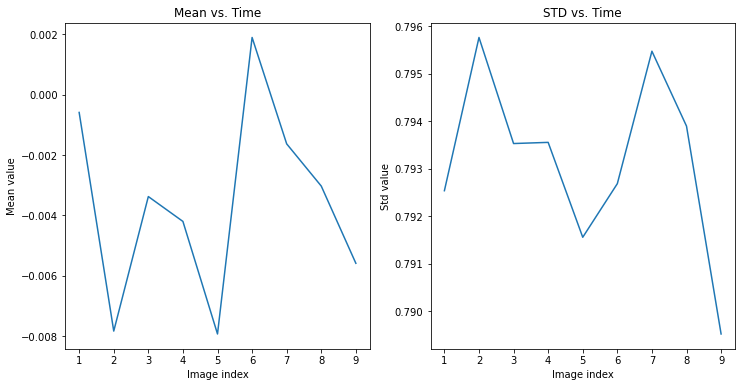

In [27]:
plt.rcParams["figure.figsize"] = (12,6)

fig,ax = plt.subplots(1,2)
ax[0].title.set_text("Mean vs. Time")
ax[0].plot(np.arange(1,10,1),means)
ax[0].set_xlabel("Image index")
ax[0].set_ylabel("Mean value")
ax[1].title.set_text("STD vs. Time")
ax[1].set_xlabel("Image index")
ax[1].set_ylabel("Std value")
ax[1].plot(np.arange(1,10,1),stds)
plt.show()

Obviously, Mean and Std varies over time, so the background is time dependent. <br><br>
Intuitively speaking, the movement of the planet should be trivial in 10 seconds. We can assume that the background in the telescope image is not moving. Let's compare the positions of the top 10 brightest stars to explain further.

In [28]:
def compare_x_signals(data,ind1,ind2,x):
    img1 = data[:,:,ind1]
    img2 = data[:,:,ind2]
    signal1 = np.sort(img1.flatten())[-x:]
    signal2 = np.sort(img2.flatten())[-x:]
    sig1_ind = []
    sig2_ind = []
    for sig in signal1:
        i, j = np.where(img1 == sig)
        sig1_ind.append((int(i),int(j)))
    for sig in signal2:
        i, j = np.where(img2 == sig)
        sig2_ind.append((int(i),int(j)))
    if set(sig1_ind)==set(sig2_ind) :
        return True
    else:
        return [sig1_ind,sig2_ind]

In [29]:
result=[]
for i in range(1,10):
    result.append(compare_x_signals(data,0,i,10))
result

[True, True, True, True, True, True, True, True, True]

The results show that the ten brightest stars are aligned at the same location in the ten pictures. Although it is not very convincing to compare only the ten brightest stars, the brightness of the stars will change, and we don't have a any method to track a specific star, so just use this way to prove it simply - the spatial consistency of the background.
<br><br>
3) To hunt for supernovae, the first step is to find "5-sigma" of each background. Then we find the points that exceed "5-sigma".

In [30]:
five_sigma =[]
for i in range(9):
    five_sigma.append(stats.norm.isf(stats.norm.sf(5),means[i],stds[i]))


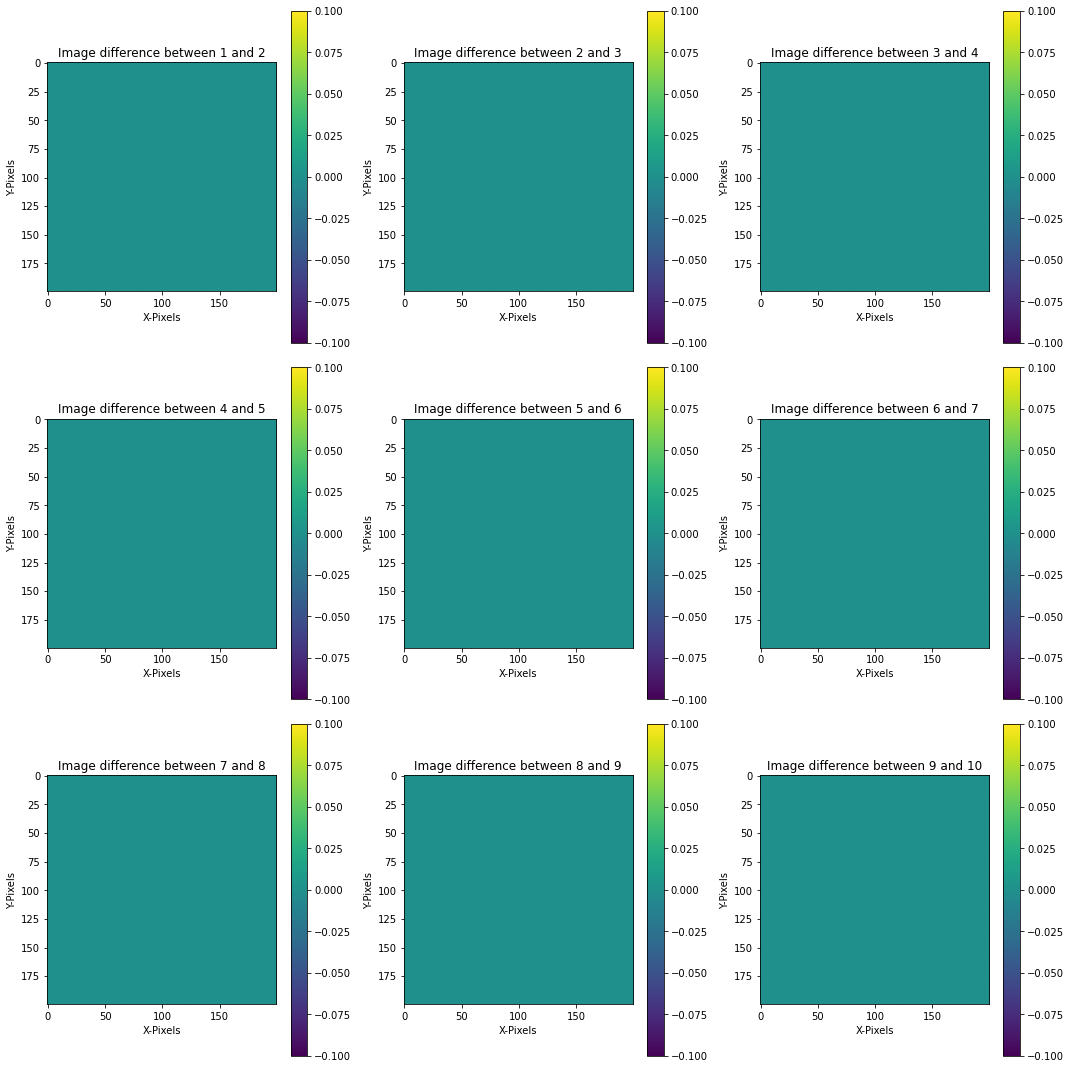

In [31]:
plt.rcParams["figure.figsize"] = (15,15)
fig,ax=plt.subplots(3,3)
for i, img in enumerate(img_diff):
    pic = ax[i//3,i%3].imshow(img*(abs(img)>five_sigma[i]))
    ax[i//3,i%3].title.set_text('Image difference between %s and %s'%((i+1),(i+2)))
    ax[i//3,i%3].set_xlabel('X-Pixels')
    ax[i//3,i%3].set_ylabel('Y-Pixels')
    fig.colorbar(pic, ax=ax[i//3,i%3])
plt.tight_layout()
plt.show()

It seems that the point above "5-sigma" does not exist. Therefore, there is no supernova in these ten pictures. To justify it, let us list the extrema of each graph.

In [32]:
for i in range(9):
    print((img_diff[i].min(), img_diff[i].max(), five_sigma[i]))

(-3.168874822282243, 3.250555510683574, 3.962102556699797)
(-3.2965908712201717, 2.876022998278034, 3.9709807603189713)
(-3.2613191797006365, 3.250511721860777, 3.964277620947831)
(-3.561630641432817, 3.3046001818587776, 3.9635762252003506)
(-3.31708187029085, 3.2409563097313483, 3.9498682678003783)
(-3.5654321790652412, 3.133892137780152, 3.9653248433444195)
(-3.1187210721464016, 3.3935635556769674, 3.9757344972672426)
(-3.1074192200013107, 3.1516212585964176, 3.9664588965338607)
(-3.853613093251055, 3.2213898116493596, 3.9420350535186657)


Means are all approaches 0, so we can conclude that the transient does not occur in these 10 images.<br><br>
4) This question is very easy to understand, because our goals are different. In order to find the faintest stars, generally we will use the entire image as the background, and the ones with more than 5-sigma are considered stars, or signals. The faintest star is the point whose brightness is the closest to the 5-sigma value.<br><br>
On the other hand, to find a supernova, we must establish the relationship between time and brightness. Because a supernova is short-lived, it is likely to only appear on a certain picture, and it does not exist on the previous and subsequent pictures. This difference in brightness should be regarded as a signal. So from the perspective of studying this problem, we should select the set of brightness differences as our background. <br><br>
In general, data is our tool, and the background is our research method. If the research goals are different, the methods we take must be different.